#### Higher school of econimics
#### Name: Zhornichenko Ilya
#### Gruop: TMSS

In [ ]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall20/week08_generative/lfw_dataset.py -O lfw_dataset.py

import torch
import numpy as np
import wget

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4


device = torch.device("cuda") # or you print here you favorite gpu card
#torch.set_default_tensor_type(torch.cuda.FloatTensor) 
# uses cuda floats by default
print(device)

In [ ]:
BATCH_SIZE = 32

In [ ]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True, dimx=38, dimy=38)
X = X.transpose([0, 3, 1, 2]).astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [ ]:
X_train_tensor = torch.from_numpy(X_train).type(torch.DoubleTensor)
X_test_tensor = torch.Tensor(X_test).type(torch.DoubleTensor)

In [ ]:
print(img_shape)

(3, 38, 38)


X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


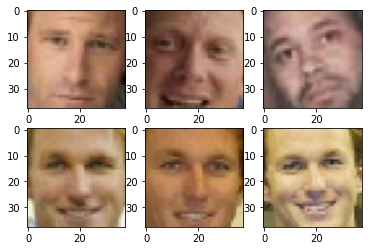

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as a single lasagne network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [ ]:
class Reshape(nn.Module):
    """ this class corresponds to torch.reshape function and may be used as a reshape layer """
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, input):
        return input.reshape(*self.shape)

In [ ]:
class PCAAutoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=50):
        super(PCAAutoencoder, self).__init__()
        self.enc = nn.Sequential(Reshape(-1, np.prod(img_shape)), nn.Linear(np.prod(img_shape), code_size))
        self.dec = nn.Sequential(nn.Linear(code_size, np.prod(img_shape)), Reshape(-1, img_shape[0], img_shape[1], img_shape[2])) 
    
    def batch_loss(self, batch, reference):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((reference - reconstruction) ** 2)
    

### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.

__Note to py2 users:__ you can safely drop `flush=True` from any code below.

In [ ]:
from tqdm import tqdm
def train(model, dataset, dataset_test, num_epoch=32, gd=None, noise_function=None, noise_function_params=None):
    model.double()
    model.to(device)
    if gd is None:
        gd = optim.Adamax(model.parameters(), lr=0.002)
    if noise_function_params is None:
        noise_function_params = {}
    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    scores = []

    for epoch in range(num_epoch):
        model.train(True)
        for i, (batch) in tqdm(enumerate(dataloader)):
            gd.zero_grad()
            if noise_function is not None:
                batch_noised = noise_function(batch, **noise_function_params).to(device=device)
                loss = model.batch_loss(batch_noised, batch.to(device=device))
            else:
                batch = batch.to(device=device)
                loss = model.batch_loss(batch, batch)
            (loss).backward()
            losses.append(loss.data.cpu().numpy())
            gd.step()
            gd.zero_grad()
        train_mse = np.mean(losses[-(i+1):])
        
        model.train(False)
        for i, (batch) in enumerate(dataloader_test):
            batch = batch.to(device=device)
            scores.append(model.batch_loss(batch, batch).data.cpu().numpy())
        test_mse  = np.mean(scores[-(i+1):])

        print(f"{epoch+1}, Train loss: {train_mse}, Test loss: {test_mse}")

In [ ]:
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    model.train(False)
    code = model.enc(img[None].cuda(device=device))

    reco = model.dec(code)

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1))
    plt.show()


In [ ]:
aenc = PCAAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 40)

370it [00:01, 192.07it/s]


1, Train loss: 0.10046233527116805, Test loss: 0.023754112040799785


370it [00:01, 309.53it/s]


2, Train loss: 0.02316420813234003, Test loss: 0.02303375540771297


370it [00:01, 301.69it/s]


3, Train loss: 0.0228581964216163, Test loss: 0.022934889073657594


370it [00:01, 289.17it/s]


4, Train loss: 0.022590789544293405, Test loss: 0.022790804335970243


370it [00:01, 308.80it/s]


5, Train loss: 0.022225897952816834, Test loss: 0.022126288048362978


370it [00:01, 309.00it/s]


6, Train loss: 0.02155457438172157, Test loss: 0.02141026224942471


370it [00:01, 299.36it/s]


7, Train loss: 0.020257822968129634, Test loss: 0.019648100505662628


370it [00:01, 363.49it/s]


8, Train loss: 0.01829097888326417, Test loss: 0.01767887086369136


370it [00:00, 385.31it/s]


9, Train loss: 0.01666190332463356, Test loss: 0.017272565141168244


370it [00:00, 379.02it/s]


10, Train loss: 0.015690391349761853, Test loss: 0.014931246839197741


370it [00:01, 369.86it/s]


11, Train loss: 0.014498488816474754, Test loss: 0.014135786022827784


370it [00:01, 296.10it/s]


12, Train loss: 0.013465424972870751, Test loss: 0.012891080323394416


370it [00:02, 126.98it/s]


13, Train loss: 0.012366761284331125, Test loss: 0.012985186545325137


370it [00:01, 276.09it/s]


14, Train loss: 0.011397657653172343, Test loss: 0.010962861947300432


370it [00:01, 277.72it/s]


15, Train loss: 0.010792361512863245, Test loss: 0.010493224815019585


370it [00:01, 294.74it/s]


16, Train loss: 0.010174854037218318, Test loss: 0.009856034062462615


370it [00:01, 340.43it/s]


17, Train loss: 0.009555567909423432, Test loss: 0.009122265667690308


370it [00:01, 367.64it/s]


18, Train loss: 0.009003131720840881, Test loss: 0.00914536366433103


370it [00:00, 371.46it/s]


19, Train loss: 0.008516219372885223, Test loss: 0.008405223840542727


370it [00:00, 382.87it/s]


20, Train loss: 0.008125293831807281, Test loss: 0.008072490406588579


370it [00:01, 369.13it/s]


21, Train loss: 0.007853184712557549, Test loss: 0.007577642961485597


370it [00:00, 377.67it/s]


22, Train loss: 0.007592026287135178, Test loss: 0.00744245824477997


370it [00:00, 384.64it/s]


23, Train loss: 0.007310131514116333, Test loss: 0.009020559187278862


370it [00:00, 384.54it/s]


24, Train loss: 0.007246484310380253, Test loss: 0.007217990791594423


370it [00:00, 379.05it/s]


25, Train loss: 0.006987021164781915, Test loss: 0.006818513660840247


370it [00:00, 382.23it/s]


26, Train loss: 0.006843860899058459, Test loss: 0.006759742155552929


370it [00:00, 374.78it/s]


27, Train loss: 0.006741811607400495, Test loss: 0.006855760691107657


370it [00:00, 380.04it/s]


28, Train loss: 0.006621987994886043, Test loss: 0.006572960937667278


370it [00:00, 383.13it/s]


29, Train loss: 0.0065260186932952725, Test loss: 0.006829481221927097


370it [00:00, 380.29it/s]


30, Train loss: 0.006443663660151811, Test loss: 0.00663464369964976


370it [00:00, 383.71it/s]


31, Train loss: 0.006362041238714175, Test loss: 0.006428921983399167


370it [00:00, 384.98it/s]


32, Train loss: 0.006254239781625998, Test loss: 0.006287989860318427


370it [00:00, 385.39it/s]


33, Train loss: 0.006160210706448524, Test loss: 0.0061111159307071375


370it [00:00, 371.50it/s]


34, Train loss: 0.006153263276116134, Test loss: 0.006036724475485904


370it [00:00, 384.95it/s]


35, Train loss: 0.00614533568752183, Test loss: 0.006259042959645037


370it [00:00, 385.82it/s]


36, Train loss: 0.006032930228929397, Test loss: 0.006166318619817724


370it [00:00, 383.48it/s]


37, Train loss: 0.006048430679732465, Test loss: 0.006014494296781829


370it [00:00, 378.74it/s]


38, Train loss: 0.005945839200671816, Test loss: 0.0070913669018631935


370it [00:00, 380.96it/s]


39, Train loss: 0.005919274718421278, Test loss: 0.005947619336216095


370it [00:00, 384.18it/s]


40, Train loss: 0.005896710552858428, Test loss: 0.005822181341009508


In [ ]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc.batch_loss(batch, batch).data.cpu().numpy())
print (np.mean(scores))

0.0058579345832552735


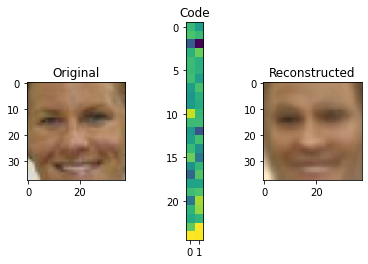

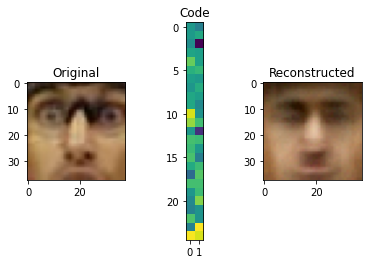

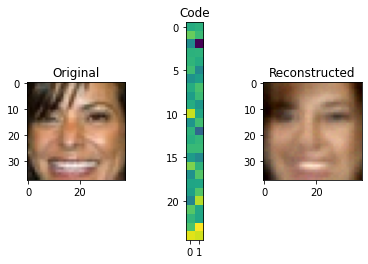

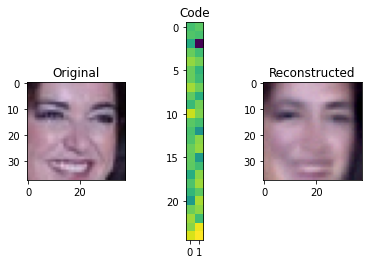

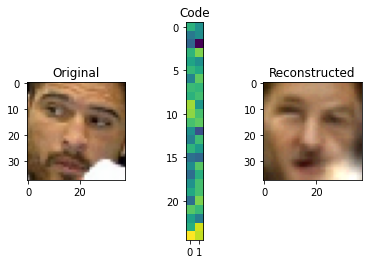

In [ ]:
for i in range(5):
    img = X_test_tensor[i]
    visualize(img, aenc)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [ ]:
class DeepAutoencoder(nn.Module):
    def __init__(self, code_size=50):
        super(DeepAutoencoder, self).__init__()
        self.enc = nn.Sequential(
            Reshape(-1, np.prod(img_shape)),
            nn.Linear(np.prod(img_shape), code_size*6),
            nn.BatchNorm1d(code_size*6),
            nn.ReLU(),
            nn.Linear(code_size*6, code_size*3),
            nn.BatchNorm1d(code_size*3),
            nn.ReLU(),
            nn.Linear(code_size*3, code_size),
            )
        self.dec = nn.Sequential(
            nn.Linear(code_size, code_size*3),
            nn.ReLU(),
            nn.Linear(code_size*3, code_size*6),
            nn.ReLU(),
            nn.BatchNorm1d(code_size*6),
            nn.Linear(code_size*6,np.prod(img_shape)),
            nn.ReLU(),
            nn.BatchNorm1d(np.prod(img_shape)),
            Reshape(-1, img_shape[0], img_shape[1], img_shape[2]))
    
    def batch_loss(self, batch, reference):
        a = self.enc(batch)
        reconstruction = self.dec(a)
        return torch.mean((reference - reconstruction)**2)

In [ ]:
#Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    help_tensor = next(iter(DataLoader(X_train_tensor, batch_size=BATCH_SIZE))).float()
    model = DeepAutoencoder(code_size).float().to(device)
    encoder_out = model.enc(help_tensor.cuda(device))
    decoder_out = model.dec(encoder_out)
    print("Testing code size %i" % code_size)

    assert encoder_out.shape[1:] == torch.Size([code_size]),"encoder must output a code of required size"
    assert decoder_out.shape[1:] == img_shape,   "decoder must output an image of valid shape"

    assert (sum([1 + len(list(c1level.children())) for c1level in model.dec.children()]) >= 6),  "decoder must contain at least 3 dense layers"

    del encoder_out
    del decoder_out
    torch.cuda.empty_cache()
print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

In [ ]:
from tqdm import tqdm
def train(model, dataset, dataset_test, num_epoch=32, gd=None, noise_function=None, noise_function_params=None):
    model.double()
    model.to(device)
    if gd is None:
        gd = optim.Adamax(model.parameters(), lr=0.002)
    if noise_function_params is None:
        noise_function_params = {}
    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    scores = []

    for epoch in range(num_epoch):
        model.train(True)
        for i, (batch) in tqdm(enumerate(dataloader)):
            gd.zero_grad()
            if noise_function is not None:
                batch_noised = noise_function(batch, **noise_function_params).to(device=device)
                loss = model.batch_loss(batch_noised, batch.to(device=device))
            else:
                batch = batch.to(device=device)
                loss = model.batch_loss(batch, batch)
            (loss).backward()
            losses.append(loss.data.cpu().numpy())
            gd.step()
            gd.zero_grad()
        train_mse = np.mean(losses[-(i+1):])
        
        model.train(False)
        for i, (batch) in enumerate(dataloader_test):
            batch = batch.to(device=device)
            scores.append(model.batch_loss(batch, batch).data.cpu().numpy())
        test_mse  = np.mean(scores[-(i+1):])

        print(f"{epoch+1}, Train loss: {train_mse}, Test loss: {test_mse}")
        if test_mse <= 0.0055:
          return

In [ ]:
aenc_deep = DeepAutoencoder()
# gd = optim.Adamax(aenc_deep.parameters(), lr=0.00)
# gd = optim.SGD(aenc_deep.parameters(), lr=0.001, momentum=0.9)
train(aenc_deep, X_train_tensor, X_test_tensor, num_epoch=100)

370it [00:03, 108.88it/s]


1, Train loss: 0.48911620548679297, Test loss: 0.140537723963526


370it [00:03, 114.18it/s]


2, Train loss: 0.06175128008512999, Test loss: 0.017910192751749713


370it [00:03, 113.81it/s]


3, Train loss: 0.013583758396252218, Test loss: 0.010144325175122619


370it [00:03, 114.00it/s]


4, Train loss: 0.010684372678675102, Test loss: 0.009787485825152207


370it [00:03, 114.16it/s]


5, Train loss: 0.010235155426405311, Test loss: 0.00927890456698857


370it [00:03, 113.75it/s]


6, Train loss: 0.009813992077515318, Test loss: 0.009122651650343127


370it [00:03, 110.42it/s]


7, Train loss: 0.009591201209385163, Test loss: 0.008875788311859114


370it [00:03, 105.30it/s]


8, Train loss: 0.009316669718789881, Test loss: 0.00859743093529686


370it [00:03, 113.12it/s]


9, Train loss: 0.009086672687995194, Test loss: 0.009119419127127165


370it [00:03, 113.38it/s]


10, Train loss: 0.008864186634088791, Test loss: 0.008723904234273015


370it [00:03, 114.13it/s]


11, Train loss: 0.008672977145615074, Test loss: 0.008282094663569007


370it [00:03, 112.13it/s]


12, Train loss: 0.008577464155805617, Test loss: 0.007798908493462002


370it [00:03, 113.57it/s]


13, Train loss: 0.00838254983570903, Test loss: 0.008357537635179916


370it [00:03, 112.61it/s]


14, Train loss: 0.008266474678912476, Test loss: 0.008042321221186696


370it [00:03, 109.08it/s]


15, Train loss: 0.008155797219208396, Test loss: 0.007524477887158745


370it [00:03, 113.12it/s]


16, Train loss: 0.008062309953505474, Test loss: 0.007493455086951405


370it [00:03, 112.43it/s]


17, Train loss: 0.007956336326174533, Test loss: 0.00799675767834167


370it [00:03, 113.00it/s]


18, Train loss: 0.007888293901467884, Test loss: 0.007296471736356132


370it [00:03, 114.63it/s]


19, Train loss: 0.007733416886454467, Test loss: 0.007398490974979663


370it [00:03, 113.83it/s]


20, Train loss: 0.007704302551530862, Test loss: 0.007097459292250817


370it [00:03, 113.53it/s]


21, Train loss: 0.007588559288603108, Test loss: 0.007080505256010898


370it [00:03, 97.91it/s] 


22, Train loss: 0.007534459555537582, Test loss: 0.006797527273483274


370it [00:03, 112.94it/s]


23, Train loss: 0.007492394028439767, Test loss: 0.007010775359004096


370it [00:03, 114.49it/s]


24, Train loss: 0.007401303651087335, Test loss: 0.006938989769181437


370it [00:03, 113.46it/s]


25, Train loss: 0.007373613181857929, Test loss: 0.0068159735259406395


370it [00:03, 113.50it/s]


26, Train loss: 0.007294182529473892, Test loss: 0.006856944178631613


370it [00:03, 114.43it/s]


27, Train loss: 0.007245508288085301, Test loss: 0.006542951632872529


370it [00:03, 112.80it/s]


28, Train loss: 0.007188199412066218, Test loss: 0.006434939498893944


370it [00:03, 113.00it/s]


29, Train loss: 0.007142548647143173, Test loss: 0.006627386115224585


370it [00:03, 113.64it/s]


30, Train loss: 0.007083764899077573, Test loss: 0.006542188281838656


370it [00:03, 112.81it/s]


31, Train loss: 0.007079309779092385, Test loss: 0.006535700752575219


370it [00:03, 112.67it/s]


32, Train loss: 0.006997832270213794, Test loss: 0.006253093155799346


370it [00:03, 113.17it/s]


33, Train loss: 0.006943855267198083, Test loss: 0.006443501154202658


370it [00:03, 112.38it/s]


34, Train loss: 0.006937894599803638, Test loss: 0.0062631521770589145


370it [00:03, 112.53it/s]


35, Train loss: 0.006877018176605607, Test loss: 0.006083723362730233


370it [00:03, 112.96it/s]


36, Train loss: 0.006859828264822883, Test loss: 0.0061856105101049125


370it [00:03, 112.83it/s]


37, Train loss: 0.006761786245052906, Test loss: 0.006033894493812742


370it [00:03, 112.22it/s]


38, Train loss: 0.006796689505501824, Test loss: 0.005916932527263005


370it [00:03, 109.14it/s]


39, Train loss: 0.006785282923657275, Test loss: 0.006045209994348215


370it [00:04, 89.82it/s]


40, Train loss: 0.006719278799080496, Test loss: 0.0060562269841269575


370it [00:03, 95.72it/s] 


41, Train loss: 0.006709852244801926, Test loss: 0.0060258890898748415


370it [00:03, 112.32it/s]


42, Train loss: 0.006648107977872172, Test loss: 0.006029968715034438


370it [00:03, 112.50it/s]


43, Train loss: 0.006657404571814601, Test loss: 0.005916175424504495


370it [00:03, 111.70it/s]


44, Train loss: 0.006631265165320664, Test loss: 0.005838895626226466


370it [00:03, 112.20it/s]


45, Train loss: 0.006624850557779743, Test loss: 0.00605724383491245


370it [00:03, 113.23it/s]


46, Train loss: 0.006615325423156256, Test loss: 0.006320731632994762


370it [00:03, 112.30it/s]


47, Train loss: 0.0065830493843165765, Test loss: 0.005886721142063374


370it [00:03, 112.77it/s]


48, Train loss: 0.006568214607468118, Test loss: 0.0060062684014002875


370it [00:03, 112.27it/s]


49, Train loss: 0.006542342914309484, Test loss: 0.005725435755522312


370it [00:03, 111.20it/s]


50, Train loss: 0.00657527011975316, Test loss: 0.00569241245387814


370it [00:03, 112.15it/s]


51, Train loss: 0.006526202905909259, Test loss: 0.005726788124416878


370it [00:03, 113.77it/s]


52, Train loss: 0.006522845144511411, Test loss: 0.005837201431591722


370it [00:03, 112.12it/s]


53, Train loss: 0.006532804295295399, Test loss: 0.005788587718199259


370it [00:03, 113.43it/s]


54, Train loss: 0.006528756684177515, Test loss: 0.005661700480192053


370it [00:03, 112.17it/s]


55, Train loss: 0.0065061213942256765, Test loss: 0.005745386609646835


370it [00:03, 112.13it/s]


56, Train loss: 0.006507786531128618, Test loss: 0.00571337149148249


370it [00:03, 112.93it/s]


57, Train loss: 0.0065069157165960605, Test loss: 0.005688862415904217


370it [00:03, 111.77it/s]


58, Train loss: 0.006456203674452947, Test loss: 0.0057456064905304655


370it [00:03, 98.93it/s]


59, Train loss: 0.0064481985564408375, Test loss: 0.005622623420566064


370it [00:04, 88.19it/s]


60, Train loss: 0.006423633712260701, Test loss: 0.005566089164546086


370it [00:03, 110.48it/s]


61, Train loss: 0.006393843930118357, Test loss: 0.005564817972838092


370it [00:03, 112.53it/s]


62, Train loss: 0.006429366119938352, Test loss: 0.005550486002525233


370it [00:03, 112.76it/s]


63, Train loss: 0.006448878217451874, Test loss: 0.005623054699250804


370it [00:03, 112.90it/s]


64, Train loss: 0.006409056705149754, Test loss: 0.005639957991017526


370it [00:03, 112.47it/s]


65, Train loss: 0.006387413288821206, Test loss: 0.005659689567922384


370it [00:03, 111.53it/s]


66, Train loss: 0.006405915117986585, Test loss: 0.005789456818068338


370it [00:03, 113.22it/s]


67, Train loss: 0.006408874515793086, Test loss: 0.0057230379300811695


370it [00:03, 112.34it/s]


68, Train loss: 0.006386798866234896, Test loss: 0.005527794858074134


370it [00:03, 113.14it/s]


69, Train loss: 0.006365635966460521, Test loss: 0.005552007876616962


370it [00:03, 112.85it/s]


70, Train loss: 0.006387780257061952, Test loss: 0.006049128561238841


370it [00:03, 112.38it/s]


71, Train loss: 0.006392923132280799, Test loss: 0.00556352500871878


370it [00:03, 112.23it/s]


72, Train loss: 0.006373886428225725, Test loss: 0.0056132536785858545


370it [00:03, 112.05it/s]


73, Train loss: 0.0063461011057965346, Test loss: 0.00558577846062718


370it [00:03, 112.23it/s]


74, Train loss: 0.006331796618014534, Test loss: 0.005579292649208934


370it [00:03, 112.63it/s]


75, Train loss: 0.0063645972963065735, Test loss: 0.0057228918422828345


370it [00:03, 112.15it/s]


76, Train loss: 0.006345941400197438, Test loss: 0.005525035604533831


370it [00:03, 111.96it/s]


77, Train loss: 0.006335350010011439, Test loss: 0.0055636069808217585


370it [00:03, 111.86it/s]


78, Train loss: 0.006339512136349048, Test loss: 0.00556239630680667


370it [00:03, 112.29it/s]


79, Train loss: 0.006370395921222033, Test loss: 0.005527348156208458


370it [00:03, 112.54it/s]


80, Train loss: 0.006345153020968627, Test loss: 0.0055892466919899315


370it [00:03, 112.47it/s]


81, Train loss: 0.006285242062699799, Test loss: 0.005574056104099993


370it [00:03, 112.64it/s]


82, Train loss: 0.006284362653795797, Test loss: 0.005519156867017886


370it [00:03, 112.53it/s]


83, Train loss: 0.0063420585624253045, Test loss: 0.005604582048926489


370it [00:03, 110.82it/s]


84, Train loss: 0.006326585320725268, Test loss: 0.005535240572751005


370it [00:03, 113.07it/s]


85, Train loss: 0.006295243751440707, Test loss: 0.005432261911858872


Training may take long, it's okay.

0.005424420524676228
50
Final MSE: 0.005424420524676228


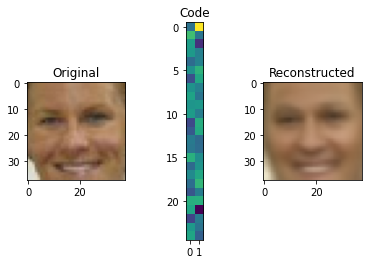

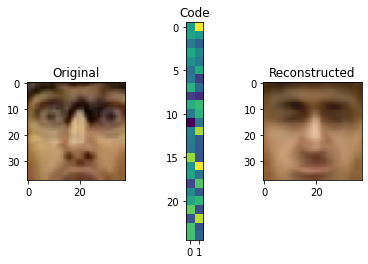

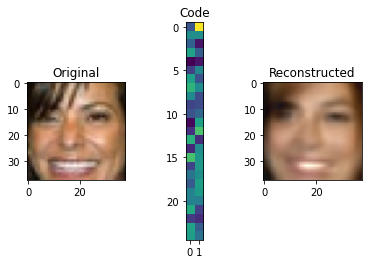

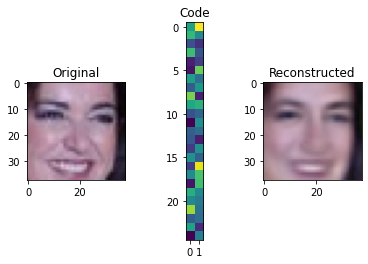

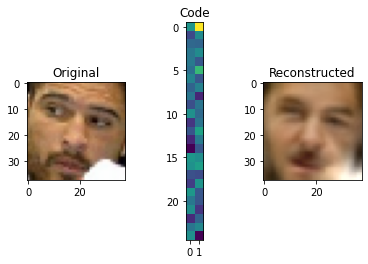

In [ ]:
aenc_deep.train(False)
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc_deep.batch_loss(batch, batch).data.cpu().numpy())
    encoder_out = aenc_deep.enc(batch)
reconstruction_mse  = np.mean(scores)
print(reconstruction_mse)
assert reconstruction_mse <= 0.0055, "Compression is too lossy. See tips below."
print(encoder_out.shape[1])
assert len(encoder_out.shape) == 2 and encoder_out.shape[1] == 50, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc_deep)

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 50 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [ ]:
def apply_gaussian_noise(X, sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    noise = torch.zeros(X.shape, dtype=torch.float64)
    noise = noise + (sigma)*torch.randn(X.shape)  
    return X + noise
    

In [ ]:
#noise tests
theoretical_std = (X[:100].std() ** 2 + 0.5 ** 2)**.5
our_std = apply_gaussian_noise(torch.from_numpy(X[:100]), sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(torch.from_numpy(X[:100]), sigma=0.5).mean() - torch.from_numpy(X[:100]).mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

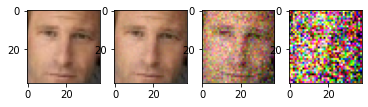

In [ ]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.01).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.1).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.5).data.numpy()[0].transpose([1,2,0]).clip(0, 1))

In [ ]:
aenc = DeepAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 50, noise_function=apply_gaussian_noise)

370it [00:04, 88.05it/s]


1, Train loss: 0.48959052297613037, Test loss: 0.12309661183075922


370it [00:04, 90.20it/s]


2, Train loss: 0.06217865836620745, Test loss: 0.018568089300410564


370it [00:05, 67.87it/s]


3, Train loss: 0.013627533030819212, Test loss: 0.010295770371411618


370it [00:04, 82.39it/s]


4, Train loss: 0.01074448317991929, Test loss: 0.009532569939308158


370it [00:05, 66.05it/s]


5, Train loss: 0.010379839286229294, Test loss: 0.009421562328500306


370it [00:04, 90.66it/s]


6, Train loss: 0.01005382443065423, Test loss: 0.009625229909175064


370it [00:03, 92.55it/s]


7, Train loss: 0.009679399682194239, Test loss: 0.00884412378043176


370it [00:04, 90.68it/s]


8, Train loss: 0.009429706751345674, Test loss: 0.008726824002220374


370it [00:04, 90.94it/s]


9, Train loss: 0.009118009025493225, Test loss: 0.008472968445898683


370it [00:04, 90.35it/s]


10, Train loss: 0.008974321682446764, Test loss: 0.008294438065791478


370it [00:04, 90.37it/s]


11, Train loss: 0.008766573760176005, Test loss: 0.008250933953034365


370it [00:04, 90.59it/s]


12, Train loss: 0.008553186664377176, Test loss: 0.008053508142458147


370it [00:04, 91.44it/s]


13, Train loss: 0.008418149439994287, Test loss: 0.00794096237736093


370it [00:04, 91.81it/s]


14, Train loss: 0.008277489181634307, Test loss: 0.007820564532610234


370it [00:04, 91.59it/s]


15, Train loss: 0.008228271855803016, Test loss: 0.007490584611359589


370it [00:04, 91.07it/s]


16, Train loss: 0.008139967359902014, Test loss: 0.0077313586113029005


370it [00:04, 90.45it/s]


17, Train loss: 0.008033043973681049, Test loss: 0.00724230776578589


370it [00:04, 90.29it/s]


18, Train loss: 0.007967659426274235, Test loss: 0.00732592245040911


370it [00:04, 90.19it/s]


19, Train loss: 0.007886145289850611, Test loss: 0.007250702936971596


370it [00:04, 90.11it/s]


20, Train loss: 0.007818550071132836, Test loss: 0.007281297898477655


370it [00:04, 90.33it/s]


21, Train loss: 0.0077590467496644186, Test loss: 0.0071332048431474475


370it [00:04, 89.88it/s]


22, Train loss: 0.00764885616618168, Test loss: 0.0071019921833096545


370it [00:04, 90.74it/s]


23, Train loss: 0.007562861477457364, Test loss: 0.006873440943822859


370it [00:04, 90.89it/s]


24, Train loss: 0.007517733625120632, Test loss: 0.006809337352307199


370it [00:04, 89.44it/s]


25, Train loss: 0.007490513552622697, Test loss: 0.0069208662200752795


370it [00:04, 88.91it/s]


26, Train loss: 0.0074273682499841655, Test loss: 0.0066080569079000695


370it [00:04, 89.08it/s]


27, Train loss: 0.007379407313728525, Test loss: 0.00653694143673255


370it [00:04, 90.51it/s]


28, Train loss: 0.007310631590114052, Test loss: 0.00652164733468026


370it [00:04, 89.44it/s]


29, Train loss: 0.007309088770858884, Test loss: 0.006553384689199763


370it [00:04, 90.14it/s]


30, Train loss: 0.007268361743829929, Test loss: 0.006415403683614775


370it [00:04, 90.07it/s]


31, Train loss: 0.007163399867792688, Test loss: 0.006405393207359609


370it [00:04, 90.26it/s]


32, Train loss: 0.007156796961396354, Test loss: 0.006422978351606538


370it [00:04, 90.34it/s]


33, Train loss: 0.007085238405257172, Test loss: 0.006385540132703272


370it [00:04, 91.00it/s]


34, Train loss: 0.007056929646773253, Test loss: 0.006521993307812089


370it [00:04, 91.94it/s]


35, Train loss: 0.00704791796796201, Test loss: 0.006018753148581464


370it [00:04, 90.64it/s]


36, Train loss: 0.006996819425692404, Test loss: 0.006181084578176161


370it [00:04, 89.29it/s]


37, Train loss: 0.0069771355123700975, Test loss: 0.006200192328079513


370it [00:04, 89.96it/s]


38, Train loss: 0.006977683354446701, Test loss: 0.006000432538376623


370it [00:04, 87.65it/s]


39, Train loss: 0.006907406959067631, Test loss: 0.00612345837088582


370it [00:04, 90.62it/s]


40, Train loss: 0.0068861344240537786, Test loss: 0.006139741214686858


370it [00:04, 90.62it/s]


41, Train loss: 0.006867724136098936, Test loss: 0.006145400812461508


370it [00:04, 90.55it/s]


42, Train loss: 0.006843146234801702, Test loss: 0.00586831288852987


370it [00:04, 91.04it/s]


43, Train loss: 0.006812066043194979, Test loss: 0.005891858149846475


370it [00:05, 73.08it/s]


44, Train loss: 0.006724479913008652, Test loss: 0.005833209804965502


370it [00:05, 72.07it/s]


45, Train loss: 0.006726257432224399, Test loss: 0.005789323914780174


370it [00:04, 90.31it/s]


46, Train loss: 0.006718211246180719, Test loss: 0.005815986729772783


370it [00:04, 89.65it/s]


47, Train loss: 0.006700227531293756, Test loss: 0.005696196007642383


370it [00:04, 90.35it/s]


48, Train loss: 0.006693782022820503, Test loss: 0.005814032091010671


370it [00:04, 90.43it/s]


49, Train loss: 0.006684474594123603, Test loss: 0.005728110209688263


370it [00:04, 90.20it/s]


50, Train loss: 0.006694329307513315, Test loss: 0.005746187230298397


__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

Final MSE: 0.005864550491537374


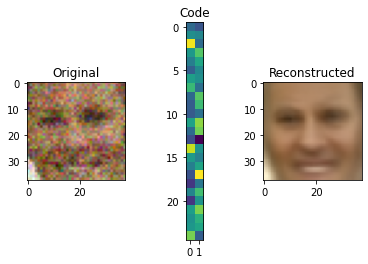

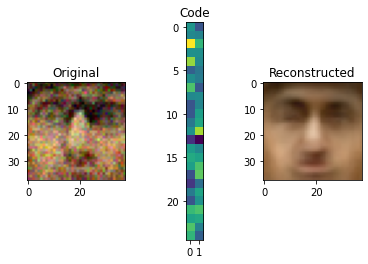

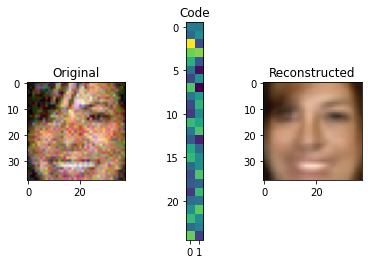

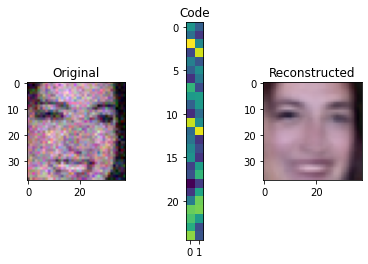

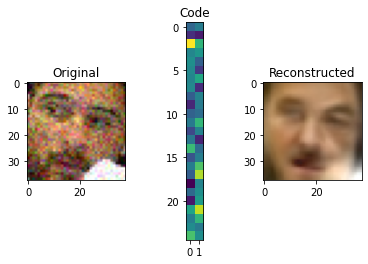

In [ ]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch_noised = apply_gaussian_noise(batch).to(device=device)
    scores.append(aenc.batch_loss(batch_noised, batch.cuda(device = device)).data.cpu().numpy())
    encoder_out = aenc.enc(batch_noised)
reconstruction_mse  = np.mean(scores)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = apply_gaussian_noise(X_test_tensor[i])
    visualize(img,aenc)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [ ]:
#encodes batch of images into a codes
imgs =  X_train_tensor
imgs = imgs.to(device)
codes = aenc.enc(imgs)
X_train_tensor.shape

torch.Size([11828, 3, 38, 38])

In [ ]:
assert codes.shape[0] == X_train_tensor.shape[0]

In [ ]:
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

In [ ]:
!pip install scikit-learn==0.20

In [ ]:
from sklearn.neighbors import NearestNeighbors
lshf = NearestNeighbors().fit(codes.detach().cpu().numpy())

In [ ]:
images = torch.from_numpy(X_train).type(torch.DoubleTensor)

In [ ]:
def get_similar(image, n_neighbors=5):
    assert len(image.shape) == 3, "image must be [batch, 3, height, width]"

    code = aenc.enc(image.cuda(device)).detach().cpu().numpy()
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [ ]:
def show_similar(image):
    distances, neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

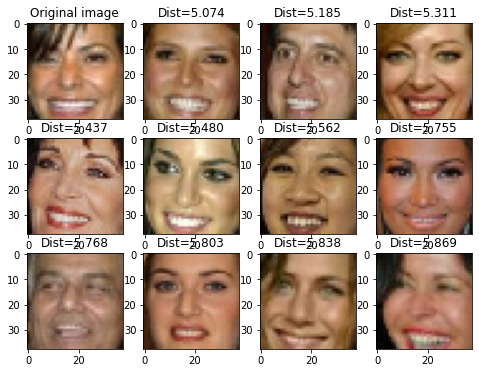

In [ ]:
#smiles
show_similar(X_test_tensor[2])

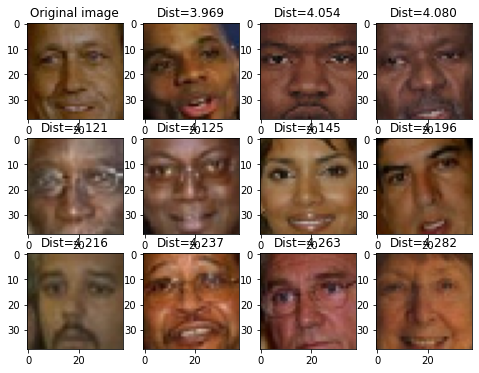

In [ ]:
#ethnicity
show_similar(X_test_tensor[500])

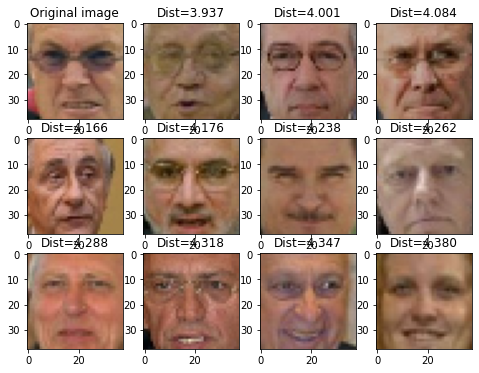

In [ ]:
#glasses
show_similar(X_test_tensor[66])

## Bonus: cheap image morphing


TypeError: ignored

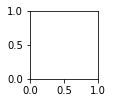

In [ ]:

for _ in range(5):
    image1,image2 = X_test_tensor[np.random.randint(0,len(X_test),size=2)]

    image_pair = torch.cat((image1,image2), 0).cuda(device)
    # ^-- note: depending on your implementation, you may need to call torch.permute here
    
    
    code1, code2 = aenc.enc(image_pair)

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = aenc.dec(output_code[None])[0]
        plt.subplot(1,7,i+1)
        plt.imshow(output_image.cpu().detach().numpy())
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.
If you want to generate images from scratch, however, you're better off using generative adversarial networks.